# Data set 7<br>
This dataset contained pedestrian footfall counts recorded in Dublin, Ireland, for 30 streets during 2022. Three variables were recorded for each street: the number of people passing in, the number of people going out, and the total number of people passing by the street regardless of their direction. It is an example of a dataset without a specific research context to determine the number of time steps for forecasting or the subset of records for the Primary Source. In this case, the first 75\% of the records representing the oldest data were used to fit the Primary Source model. <br>
## Preliminaries<br>
Import and load the uses Python packages and modules:

In [1]:
import sys
import os
# Add the parent directory to sys.path
parent_directory = os.path.abspath(os.path.join(os.getcwd(), '../main/'))
sys.path.insert(0, parent_directory)
import pandas as pd
import numpy as np
import sim_experiments as smexp_dyn
from datetime import date

Load the data set and prepare it:

In [2]:
df = pd.read_csv("../datasets/ds07-pedestrian-counts-2022.csv", delimiter=",")
df["Date"] = pd.to_datetime(df["Time"],format = '%d/%m/%Y %H:%M')
df["MonthYear"] = df["Date"].dt.to_period('M')
df["Time"] = df["Date"].dt.time
df.set_index(["Date"], inplace=True)
dfnum = df.select_dtypes(include=[float, int])
from datetime import datetime
date_time = [lambda x: x.strftime("%m/%d/%Y, %H:%M:%S") for x in list(dfnum.index.values)]
dfnum.index = date_time

Exploratory analysis showing time series decomposigion as an additive model where each time instant ($x_i$) is the addition of a trend component ($T_i$), a seasonal component ($S_i$) and an error component ($E_i$)

In [3]:
smexp_dyn.plot_time_components_div(dfnum, dfnum.iloc[:int(0.75*len(dfnum)),:].index, dfnum.iloc[int(0.75*len(dfnum)):,:].index, 24*7,
                                   dsname="ds07comb", xtxtsize=4, onlydate=False, path_figs="../figures/")

'done'

## Primary Source models<br>
Obtain the parameters for the reference batch of data. The function returns a dictionary *ps_dict* with the parameters to compute each one of the drift metrics according to a different ML model and the _indPS_ variable with the indices of the records used for the reference set.

Step [1/6]: Printing the Original Data Set Features =======
Step [1/6]: Starting ...
       Aston Quay/Fitzgeralds  Aston Quay/Fitzgeralds IN  \
count             4608.000000                4608.000000   
mean              2600.377604                1229.732856   
std               1394.817988                 633.302812   
min                  0.000000                   0.000000   
25%               1379.750000                 729.000000   
50%               2844.500000                1310.500000   
75%               3651.000000                1677.250000   
max               6388.000000                3225.000000   

       Aston Quay/Fitzgeralds OUT  Bachelors walk/Bachelors way  \
count                 4608.000000                   8759.000000   
mean                  1370.644748                   1190.548921   
std                    785.043501                    882.518280   
min                      0.000000                      0.000000   
25%                    653.000000      

2023-11-21 18:25:51.967726: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "my_ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 74)                7400      
                                                                 
 sequential_1 (Sequential)   (None, 99)                7425      
                                                                 
Total params: 14,825
Trainable params: 14,825
Non-trainable params: 0
_________________________________________________________________
Best model - DONE
Data model -  DONE
Permutation test -  DONE
dE-AE summary: 1386.3359429836273 s.; 640 b.
Step [3/6]: Finished.


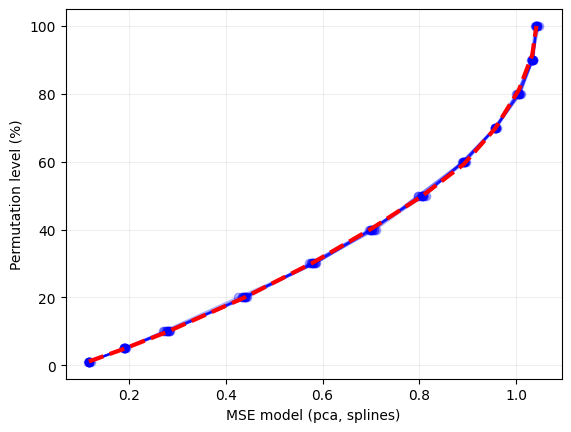

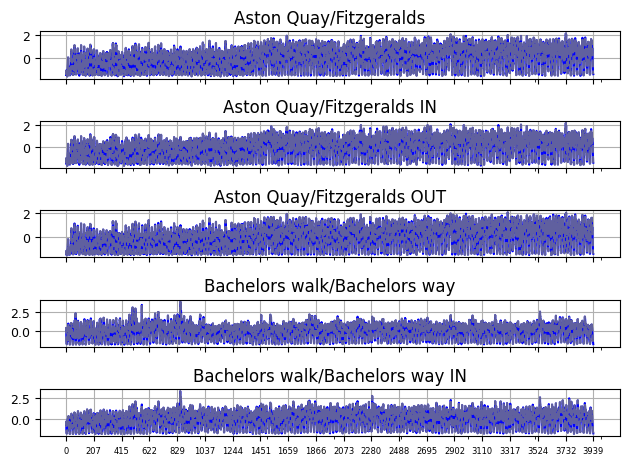

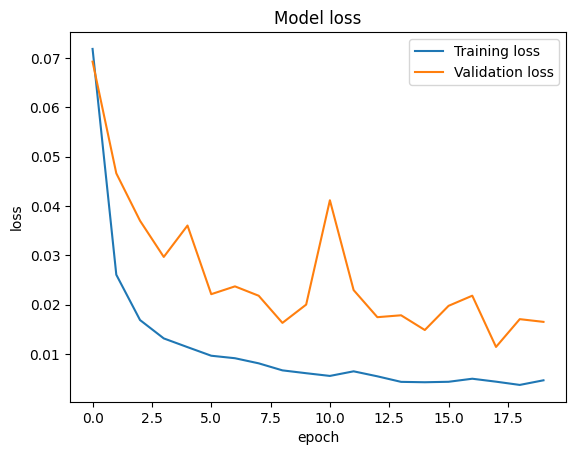

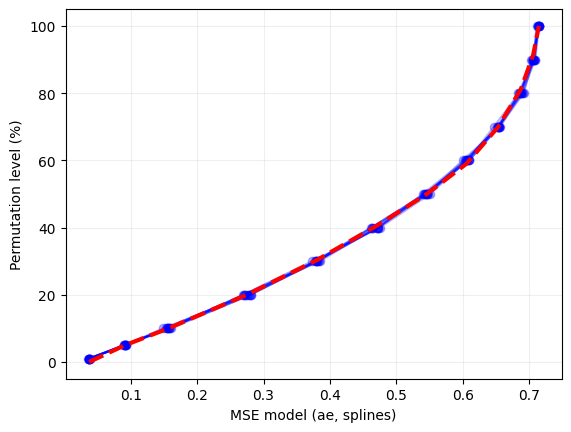

In [4]:
import random
import tensorflow as tf
tf.random.set_seed(42) 
np.random.seed(42)
random.seed(42)
print("Doing Primary Source Model -- \n" + "N = " + str(np.round(0.75*len(dfnum))) + " (" + str(np.round(np.round(0.75*len(dfnum))/(len(dfnum)*100,2))) + 
      " %" + " of total dataset length)")
ps_dict, ind_PS = smexp_dyn.get_PS_data(dfnum, resultspath = "../results/ds07/", dstitle = "DS 07 PS", PSfilename = "ds07ps.pkl", pctge_PS=0.75,
                                        mse_model_type="splines",resultsfile = "/dyn-ds-07")
# %%
X_PS = dfnum.loc[list(ind_PS),:].copy()
X_NEW = dfnum.drop(index=list(ind_PS)).copy()

### New versions<br>
When a new version of the dataset is generated, it will be compared to the information from the previous version in the following way:<br>
  * $d_{P}$: computes the cosine distance between loading matrices obtained for both data sets;<br>
  * $d_{E, PCA}$: computes the MSE obtained by reconstructing the new batch using the reference PCA model. This value is fed into a quadratic model fitted with the reference data set, which relates MSE values to levels of corruption artificially simulated by permuting entries from the reference set.<br>
  * $d_{E, AE}$: computes the MSE obtained by reconstructing the new batch using the reference AE model. This value is fed into a quadratic model fitted with the reference data set, which relates MSE values to levels of corruption artificially simulated by permuting entries from the reference set.<br>


## Creation events<br>
The following experiments use an initial subset as reference and add new batches of different size.

In [5]:
print("  - Case 1: add rows of new set \n")
try:
    smexp_dyn.do_exp(X_NEW, ps_dict, resultspath = "../results/ds07", mode_der = "add_batch",
                     batchsize_pctges = [0.05, 0.1, 0.25, 0.5, 0.75, 1], dstitle="DS 07 batch addition", 
                     resultsfile="/dyn-ds-07-add", fixedvariables=ps_dict["PS_dic"]["PCA"]["E"]["vbles_in_prepro"])
except Exception as e: print(e)

  - Case 1: add rows of new set 

New versions, level 0.05- start
New versions, level 0.05- end
New versions, level 0.1- start
New versions, level 0.1- end
New versions, level 0.25- start
New versions, level 0.25- end
New versions, level 0.5- start
New versions, level 0.5- end
New versions, level 0.75- start
New versions, level 0.75- end
New versions, level 1- start
New versions, level 1- end
DER: done


## Update events<br>

In [6]:
print("  - Case 2.1: transform columns ..\n")
try: 
    smexp_dyn.do_exp(X_PS, ps_dict, resultspath = "../results/ds07", mode_der = "trans_cols",
                    tr_pctges = [0.05, 0.1, 0.3, 0.5, 0.7, 0.8, 1], dstitle="DS 06 cbrt scale", batchsize_pctges=[1], kfolds=1,
                    modetr="cbrt",resultsfile="/fixed-ds-07-trcols-cbrt")
except Exception as e: print(e)

  - Case 2.1: transform columns ..

New versions, level 0.05- start
New versions, level 0.05- end
New versions, level 0.1- start
New versions, level 0.1- end
New versions, level 0.3- start
New versions, level 0.3- end
New versions, level 0.5- start
New versions, level 0.5- end
New versions, level 0.7- start
New versions, level 0.7- end
New versions, level 0.8- start
New versions, level 0.8- end
New versions, level 1- start
New versions, level 1- end
DER: done


## Deletion events<br>
In the following cases, the reference set contains all the records and some of them are deleted in different ways: signals are down sampled, outliers are removed, etc.

In [7]:
print("  - Case 1.2: remove rows decimate .. \n")
try:
    smexp_dyn.do_exp(X_PS, ps_dict, resultspath = "../results/ds07", mode_der = "rem_rows_decimate", 
                     tr_pctges = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05], dstitle="DS 07 decimate", resultsfile="/fixed-ds-07-downsample")
except Exception as e: print(e)

  - Case 1.2: remove rows decimate .. 

New versions, level 0.5- start
New versions, level 0.5- end
New versions, level 0.4- start
New versions, level 0.4- end
New versions, level 0.3- start
New versions, level 0.3- end
New versions, level 0.2- start
New versions, level 0.2- end
New versions, level 0.1- start
New versions, level 0.1- end
New versions, level 0.05- start
New versions, level 0.05- end
DER: done
